
# 8. Long Short-Term Memory (LSTM) network with PyTorch
## 1. About LSTMs: Special RNN
- Capable of learning long-term dependencies
- LSTM = RNN on super juice

### 1.1 RNN Transition to LSTM
<img src="./images/lstm0n2.png" alt="deeplearningwizard" style="width: 900px;"/>

## 2. Building an LSTM with PyTorch

### Model A: 1 Hidden Layer
- Unroll 28 time steps
    - Each step input size: 28 x 1
    - Total per unroll: 28 x 28
        - Feedforward Neural Network input size: 28 x 28 
- 1 Hidden layer

<img src="./images/lstm1.png" alt="deeplearningwizard" style="width: 900px;"/>

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- Step 4: Instantiate Model Class
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model

### Step 1: Loading MNIST Train Dataset
**Images from 1 to 9**

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [13]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [14]:
print(train_dataset.train_data.size())

torch.Size([60000, 28, 28])


In [15]:
print(train_dataset.train_labels.size())

torch.Size([60000])


In [16]:
print(test_dataset.test_data.size())

torch.Size([10000, 28, 28])


In [17]:
print(test_dataset.test_labels.size())

torch.Size([10000])


### Step 2: Make Dataset Iterable

In [18]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Step 3: Create Model Class

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

### Step 4: Instantiate Model Class
- 28 time steps
    - Each time step: input dimension = 28
- 1 hidden layer
- MNIST 1-9 digits $\rightarrow$ output dimension = 10

In [20]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

In [21]:
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

### Step 5: Instantiate Loss Class
- Long Short-Term Memory Neural Network: **Cross Entropy Loss**
    - _Recurrent Neural Network_: **Cross Entropy Loss**
    - _Convolutional Neural Network_: **Cross Entropy Loss**
    - _Feedforward Neural Network_: **Cross Entropy Loss**
    - _Logistic Regression_: **Cross Entropy Loss**
    - _Linear Regression_: **MSE**
    

In [22]:
criterion = nn.CrossEntropyLoss()

### Step 6: Instantiate Optimizer Class
- Simplified equation
    - $\theta = \theta - \eta \cdot \nabla_\theta $
        - $\theta$: parameters (our variables)
        - $\eta$: learning rate (how fast we want to learn)
        - $\nabla_\theta$: parameters' gradients
- Even simplier equation
    - `parameters = parameters - learning_rate * parameters_gradients`
    - **At every iteration, we update our model's parameters**

In [23]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

### Parameters In-Depth

In [24]:
len(list(model.parameters()))

6

In [25]:
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])


#### Parameters
- **Input** $\rightarrow$ **Gates**
    - $[400, 28] \rightarrow w_1, w_3, w_5, w_7$
    - $[400] \rightarrow b_1, b_3, b_5, b_7$
- **Hidden State** $\rightarrow$ **Gates**
    - $[400,100] \rightarrow w_2, w_4, w_6, w_8$
    - $[400] \rightarrow b_2, b_4, b_6, b_8$
- **Hidden State** $\rightarrow$ **Output**
    - $[10, 100] \rightarrow w_9 $
    - $[10] \rightarrow b_9$

<img src="./images/lstm2.png" alt="deeplearningwizard" style="width: 700px;"/>

### Step 7: Train Model
- Process 
    1. **Convert inputs/labels to variables**
        - LSTM Input: (1, 28)
        - RNN Input: (1, 28)
        - CNN Input: (1, 28, 28) 
        - FNN Input: (1, 28*28)
    2. Clear gradient buffets
    3. Get output given inputs 
    4. Get loss
    5. Get gradients w.r.t. parameters
    6. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    7. REPEAT

I put this next model back to what I think is working 

In [38]:


accumulation_steps = 10
batch_size = 100 // accumulation_steps
n_iters = 30000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
# learning_rate = 0.5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Number of steps to unroll
seq_dim = 28  
# accumulation_steps = 10
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        # optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) / accumulation_steps

        # should be dividing the loss by the accumulation steps here I reckon, but my results work better without this.
        
        # # Getting gradients w.r.t. parameters
        loss.backward()
        
        if ((i+1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):

            # optimizer.zero_grad()

            # Getting gradients w.r.t. parameters
            # loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        # Updating parameters
        # optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize images
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.22808392345905304. Accuracy: 11.430000305175781
Iteration: 1000. Loss: 0.22944489121437073. Accuracy: 11.350000381469727
Iteration: 1500. Loss: 0.2315853089094162. Accuracy: 11.430000305175781
Iteration: 2000. Loss: 0.2249087393283844. Accuracy: 19.09000015258789
Iteration: 2500. Loss: 0.2318643033504486. Accuracy: 12.630000114440918
Iteration: 3000. Loss: 0.231770321726799. Accuracy: 12.770000457763672
Iteration: 3500. Loss: 0.22829969227313995. Accuracy: 18.280000686645508
Iteration: 4000. Loss: 0.2249705046415329. Accuracy: 16.170000076293945
Iteration: 4500. Loss: 0.22302763164043427. Accuracy: 18.280000686645508
Iteration: 5000. Loss: 0.2231067419052124. Accuracy: 18.8799991607666
Iteration: 5500. Loss: 0.22243599593639374. Accuracy: 18.34000015258789
Iteration: 6000. Loss: 0.22698840498924255. Accuracy: 18.15999984741211
Iteration: 6500. Loss: 0.2209179401397705. Accuracy: 25.239999771118164
Iteration: 7000. Loss: 0.21510593593120575. Accuracy: 27.23999977

batch size 100 // accum_Step = 10

number of itrs = 30000

Iteration: 500. Loss: 0.552817165851593. Accuracy: 82.41999816894531

Iteration: 1000. Loss: 0.12617383897304535. Accuracy: 94.94000244140625

Iteration: 1500. Loss: 0.04816253483295441. Accuracy: 97.04000091552734

Iteration: 2000. Loss: 0.07681174576282501. Accuracy: 97.75

Iteration: 2500. Loss: 0.07728324085474014. Accuracy: 98.08999633789062

In [34]:

accumulation_steps = 10
batch_size = 100 // accumulation_steps
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()

# learning rate = 0.1
learning_rate = 0.5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Number of steps to unroll
seq_dim = 28  
# accumulation_steps = 10
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        # optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # should be dividing the loss by the accumulation steps here I reckon, but my results work better without this.
        
        # # Getting gradients w.r.t. parameters
        loss.backward()
        
        if ((i+1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):

            # optimizer.zero_grad()

            # Getting gradients w.r.t. parameters
            # loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        # Updating parameters
        # optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize images
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

This is the aim:

Iteration: 500. Loss: 2.265331506729126. Accuracy: 19.190000534057617

Iteration: 1000. Loss: 0.9522631764411926. Accuracy: 66.44000244140625

Iteration: 1500. Loss: 0.4156094491481781. Accuracy: 84.1500015258789

Iteration: 2000. Loss: 0.2358238250017166. Accuracy: 92.55999755859375

Iteration: 2500. Loss: 0.25919219851493835. Accuracy: 91.38999938964844

Iteration: 3000. Loss: 0.05853457748889923. Accuracy: 95.70999908447266

### Model B: 2 Hidden Layer 
- Unroll 28 time steps
    - Each step input size: 28 x 1
    - Total per unroll: 28 x 28
        - Feedforward Neural Network inpt size: 28 x 28 
- **2 Hidden layer**

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- **Step 4: Instantiate Model Class**
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# JUST PRINTING MODEL & PARAMETERS 
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  

accumulation_steps = 10
iter = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(train_loader):
        # Load images as torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # if ((i+1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):
            # optimizer.step()
            # optimizer.zero_grad()

        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize image
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

LSTMModel(
  (lstm): LSTM(28, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
10
torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])
Iteration: 500. Loss: 2.288797378540039. Accuracy: 13.289999961853027
Iteration: 1000. Loss: 1.098772406578064. Accuracy: 57.4900016784668
Iteration: 1500. Loss: 0.9006298780441284. Accuracy: 77.33999633789062
Iteration: 2000. Loss: 0.4344133734703064. Accuracy: 91.08000183105469
Iteration: 2500. Loss: 0.2367284893989563. Accuracy: 94.58000183105469
Iteration: 3000. Loss: 0.117561474442482. Accuracy: 95.69000244140625


## Hidden layer Grad Accum

In [ ]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# # JUST PRINTING MODEL & PARAMETERS 
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  

accumulation_steps = 10
iter = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(train_loader):
        # Load images as torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # if ((i+1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):
            # optimizer.step()
            # optimizer.zero_grad()

        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize image
                images = images.view(-1, seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

#### Parameters (Layer 1)
- **Input** $\rightarrow$ **Gates**
    - $[400, 28]$
    - $[400]$
- **Hidden State** $\rightarrow$ **Gates**
    - $[400,100]$
    - $[400]$
   
#### Parameters (Layer 2)
- **Input** $\rightarrow$ **Gates** 
    - $[400, 100]$
    - $[400]$
- **Hidden State** $\rightarrow$ **Gates** 
    - $[400,100]$
    - $[400]$
   
#### Parameters (Readout Layer)
- **Hidden State** $\rightarrow$ **Output**
    - $[10, 100]$
    - $[10]$

### Model C: 3 Hidden Layer 
- Unroll 28 time steps
    - Each step input size: 28 x 1
    - Total per unroll: 28 x 28
        - Feedforward Neural Network inpt size: 28 x 28 
- **3 Hidden layer**

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- **Step 4: Instantiate Model Class**
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model


In [106]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

## accumulation_steps
accumulation_steps = 10
batch_size = 2000 / accumulation_steps
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# JUST PRINTING MODEL & PARAMETERS 
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = images.view(-1, seq_dim, input_dim).requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

LSTMModel(
  (lstm): LSTM(28, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
14
torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])
Iteration: 500. Loss: 2.3018665313720703. Accuracy: 11.350000381469727
Iteration: 1000. Loss: 2.2952382564544678. Accuracy: 11.350000381469727
Iteration: 1500. Loss: 1.7005929946899414. Accuracy: 39.0099983215332
Iteration: 2000. Loss: 0.6987354755401611. Accuracy: 76.45999908447266
Iteration: 2500. Loss: 0.4393642842769623. Accuracy: 86.72000122070312
Iteration: 3000. Loss: 0.21182510256767273. Accuracy: 94.18000030517578


#### Parameters (Layer 1)
- **Input** $\rightarrow$ **Gates**
    - [400, 28]
    - [400]
- **Hidden State** $\rightarrow$ **Gates**
    - [400,100]
    - [400]
   
#### Parameters (Layer 2)
- **Input** $\rightarrow$ **Gates** 
    - [400, 100]
    - [400]
- **Hidden State** $\rightarrow$ **Gates** 
    - [400,100]
    - [400]

  

#### Parameters (Layer 3)
- **Input** $\rightarrow$ **Gates** 
    - [400, 100]
    - [400]
- **Hidden State** $\rightarrow$ **Gates** 
    - [400,100]
    - [400]

    
#### Parameters (Readout Layer)
- **Hidden State** $\rightarrow$ **Output**
    - [10, 100]
    - [10]

### Comparison with RNN
| Model A RNN | Model B RNN   | Model C RNN | 
|------|------|
|   ReLU | ReLU | Tanh |
| 1 Hidden Layer | 2 Hidden Layers | 3 Hidden Layers | 
| 100 Hidden Units | 100 Hidden Units |100 Hidden Units |
| 92.48% | 95.09% | 95.54% | 

| Model A LSTM | Model B LSTM   | Model C LSTM | 
|------|------|
| 1 Hidden Layer | 2 Hidden Layers | 3 Hidden Layers |
| 100 Hidden Units | 100 Hidden Units |100 Hidden Units |
| 96.05% | 95.24% | 91.22% | 




### Deep Learning
- 2 ways to expand a recurrent neural network
    - More hidden units
         - `(o, i, f, g) gates`
    - More hidden layers
- Cons
    - Need a larger dataset
        - Curse of dimensionality
    - Does not necessarily mean higher accuracy

## 3. Building a Recurrent Neural Network with PyTorch (GPU)

### Model A: 3 Hidden Layers

GPU: 2 things must be on GPU
- `model`
- `tensors`

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- **Step 3: Create Model Class**
- **Step 4: Instantiate Model Class**
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- **Step 7: Train Model**

This next cell I will be trying to implement gradient accumulation. With my GPU, a batch size of 7500 will fit into ram but a batch size of 7600 will not. The aim of this report will be to try and make this batch size fit.

In [42]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

accuracyArr = []
train_losses = []


# plt.figure(figsize=(10,5))
# plt.title("Training and Validation Loss")
# plt.plot(val_losses,label="val")
# plt.plot(train_losses,label="train")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# writer = SummaryWriter()

# torch.cuda.set_per_process_memory_fraction(0.5, 0)
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                        train=False, 
                        transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''
accumulation_steps = 5
batch_size = 20
#0 // accumulation_steps
# n_iters = 5000
n_iters = 8000
## note the len of the train_dataset is 60000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
    
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1
# learning_rate = 0.5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  


iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
            
        # # Clear gradients w.r.t. parameters
        # optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) #/ accumulation_steps
        
        ## this is potentially needed to normalize our loss if our loss is averaged
        # loss = loss / accumulation_steps
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):
        # if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            optimizer.step()
            optimizer.zero_grad()

        # Updating parameters
        # optimizer.step()
        # optimizer.zero_grad()
        
        iter += 1
            
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            train_losses.append(loss.item())

            accuracyArr.append(accuracy)

            # for use with tensorboard, not working
            # writer.add_scalar('Loss/train', loss.item(), iter)
            # writer.add_scalar('Accuracy/train', accuracy, iter)
            # writer.close()

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}. Epoch: {}'.format(iter, loss.item(), accuracy, epoch))
            print(torch.cuda.memory_summary(abbreviated=False))

Iteration: 500. Loss: 2.316282272338867. Accuracy: 10.279999732971191. Epoch: 0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 4         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   18098 KB |  477864 KB |   11212 GB |   11212 GB |
|       from large pool |   15250 KB |  474448 KB |   10838 GB |   10838 GB |
|       from small pool |    2847 KB |    7400 KB |     374 GB |     374 GB |
|---------------------------------------------------------------------------|
| Active memory         |   18098 KB |  477864 KB |   11212 GB

without div
Iteration: 500. Loss: 2.290450096130371. Accuracy: 11.350000381469727

Iteration: 1000. Loss: 2.300975799560547. Accuracy: 11.350000381469727

Iteration: 1500. Loss: 2.2891440391540527. Accuracy: 11.350000381469727

Iteration: 2000. Loss: 2.298623561859131. Accuracy: 20.040000915527344

Iteration: 2500. Loss: 1.5900005102157593. Accuracy: 42.11000061035156

Iteration: 3000. Loss: 1.3344417810440063. Accuracy: 58.38999938964844

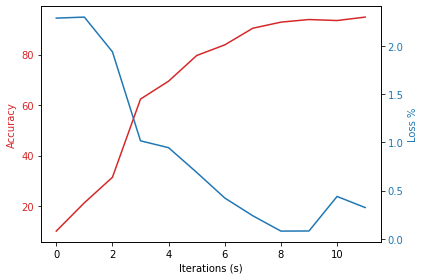

In [41]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations (s)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(accuracyArr, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss %', color=color)  # we already handled the x-label with ax1
ax2.plot(train_losses, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

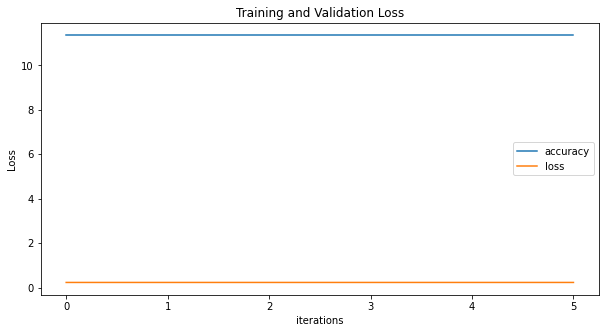

In [15]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(accuracyArr, label="accuracy")
plt.plot(train_losses,label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

grad_accu without loss / by accum steps

Iteration: 500. Loss: 2.3048462867736816. Accuracy: 11.350000381469727

Iteration: 1000. Loss: 2.29508638381958. Accuracy: 11.350000381469727

Iteration: 1500. Loss: 2.2026185989379883. Accuracy: 24.709999084472656

Iteration: 2000. Loss: 2.4915976524353027. Accuracy: 7.699999809265137

Iteration: 2500. Loss: 1.0642483234405518. Accuracy: 61.38999938964844

Iteration: 3000. Loss: 0.7956912517547607. Accuracy: 75.81999969482422


grad accum with / by accum steps

Iteration: 500. Loss: 0.2304486334323883. Accuracy: 11.350000381469727

Iteration: 1000. Loss: 0.23037873208522797. Accuracy: 11.350000381469727

Iteration: 1500. Loss: 0.22993922233581543. Accuracy: 11.350000381469727

Iteration: 2000. Loss: 0.23011620342731476. Accuracy: 11.350000381469727

The following is the final non grad accum that I am using. 

In [44]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

accuracyArrNoGradAccum = []
train_lossesNoGradAccum = []


# plt.figure(figsize=(10,5))
# plt.title("Training and Validation Loss")
# plt.plot(val_losses,label="val")
# plt.plot(train_losses,label="train")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# writer = SummaryWriter()

# torch.cuda.set_per_process_memory_fraction(0.5, 0)
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                        train=False, 
                        transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''
# accumulation_steps = 10
batch_size = 32
# n_iters = 100
n_iters = 3000
## note the len of the train_dataset is 60000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
    
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  


iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
            
        # # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):
        # # if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
        #     optimizer.step()
        #     optimizer.zero_grad()

        # Updating parameters
        optimizer.step()
        
        iter += 1
            
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            train_lossesNoGradAccum.append(loss.item())

            accuracyArrNoGradAccum.append(accuracy)

            # for use with tensorboard, not working
            # writer.add_scalar('Loss/train', loss.item(), iter)
            # writer.add_scalar('Accuracy/train', accuracy, iter)
            # writer.close()

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}. Epoch: {}'.format(iter, loss.item(), accuracy, epoch))
            print(torch.cuda.memory_summary(abbreviated=False))

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

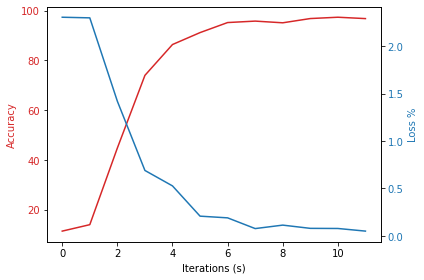

In [43]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations (s)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(accuracyArrNoGradAccum, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss %', color=color)  # we already handled the x-label with ax1
ax2.plot(train_lossesNoGradAccum, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
lstmModel(100)

Iteration: 500. Loss: 2.304459810256958. Accuracy: 11.350000381469727


In [43]:
torch.cuda.empty_cache()

In [19]:
print(len(train_dataset))

60000


In [30]:
print(300 / (len(train_dataset) / 10000))

50.0


In [23]:
print(n_iters / (len(train_dataset) / 100))

50.0


In [171]:
torch.cuda.list_gpu_processes(device=0)

'GPU:0\nprocess      28952 uses     2459.000 MB GPU memory'

In [170]:
torch.cuda.memory_summary(device=0)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 64           |        cudaMalloc retries: 66        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  117757 KB |    2163 MB |   11996 GB |   11996 GB |\n|       from large pool |  113159 KB |    2160 MB |   11956 GB |   11956 GB |\n|       from small pool |    4598 KB |       9 MB |      40 GB |      40 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  117757 KB |    2163 MB |   11996 GB |   11996 GB |\n|       from large pool |  113159 KB |    2160 MB |

In [1]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# def lstmModel(batch_size):
    # torch.cuda.set_per_process_memory_fraction(0.5, 0)
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                        train=False, 
                        transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

accumulation_steps = 10
batch_size = 10000 // accumulation_steps
# n_iters = 1000
n_iters = 3000
## note the len of the train_dataset is 60000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
    
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  

## accumulation_steps
# accumulation_steps = 10

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
            
        # # Clear gradients w.r.t. parameters
        # optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) / accumulation_steps
        
        ## this is potentially needed to normalize our loss if our loss is averaged
        # loss = loss / accumulation_steps
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):
        # if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            optimizer.step()                            # Now we can do an optimizer step
            optimizer.zero_grad()                           # Reset gradients tensors

        # Updating parameters
        # optimizer.step()
        
        iter += 1
            
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            # model.zero_grad()                           # Reset gradients tensors

KeyboardInterrupt: 

Results without grad accum and

Iteration: 500. Loss: 2.2964327335357666. Accuracy: 11.350000381469727

Iteration: 1000. Loss: 2.2962512969970703. Accuracy: 11.359999656677246

Iteration: 1500. Loss: 1.9343382120132446. Accuracy: 29.65999984741211

Iteration: 2000. Loss: 0.7669856548309326. Accuracy: 72.06999969482422

Iteration: 2500. Loss: 0.4916616678237915. Accuracy: 85.75

Iteration: 3000. Loss: 0.1785622239112854. Accuracy: 93.44999694824219

Results with gradient accum without / by accum_step

Iteration: 500. Loss: 2.301828145980835. Accuracy: 11.350000381469727

Iteration: 1000. Loss: 2.2957465648651123. Accuracy: 11.350000381469727

Iteration: 1500. Loss: 2.096222162246704. Accuracy: 17.270000457763672

Iteration: 2000. Loss: 1.7537957429885864. Accuracy: 37.02000045776367

Iteration: 2500. Loss: 1.263187050819397. Accuracy: 55.880001068115234

Iteration: 3000. Loss: 0.9184436798095703. Accuracy: 69.97000122070312

This next one is the comparsion of the lstm without grad accum

In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
# from pytorch_memlab import MemReporter
# import cProfile
# import re

# cProfile.run('re.compile("foo|bar")')

# def lstmModel(batch_size):
    # torch.cuda.set_per_process_memory_fraction(0.5, 0)
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                        train=False, 
                        transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

accumulation_steps = 10
batch_size = 2000
#  // accumulation_steps
# batch_size = 4000
# n_iters = 1000
n_iters = 3000
## note the len of the train_dataset is 60000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
# reporter = MemReporter(model)
# reporter.report()
#######################
#  USE GPU FOR MODEL  #
#######################
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
    
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28  

## accumulation_steps
# accumulation_steps = 10

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
            
        # # Clear gradients w.r.t. parameters
        # optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # / accumulation_steps
        
        ## this is potentially needed to normalize our loss if our loss is averaged
        # loss = loss / accumulation_steps
        
        # reporting memory usage
#         reporter.report()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # reporting memory usage
#         reporter.report()

        # Gadient accumulation
        if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_dataset)):
            optimizer.step()                            # Now we can do an optimizer step
            optimizer.zero_grad()                           # Reset gradients tensors

        # Updating parameters
        # optimizer.step()
        
        iter += 1
            
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            # torch.cuda.memory_summary(device=None, abbreviated=False)
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}. Epoch: {}'.format(iter, loss.item(), accuracy, epoch))
            print(torch.cuda.memory_summary(abbreviated=False))
            # model.zero_grad()                           # Reset gradients tensors

RuntimeError: CUDA out of memory. Tried to allocate 364.00 MiB (GPU 0; 3.95 GiB total capacity; 344.12 MiB already allocated; 80.75 MiB free; 480.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [203]:
lstmModel(100)

Iteration: 500. Loss: 2.290384292602539. Accuracy: 10.279999732971191


# Summary

- RNN transition to LSTM
- LSTM Models in PyTorch
    - Model A: 1 Hidden Layer LSTM
    - Model B: 2 Hidden Layer LSTM
    - Model C: 3 Hidden Layer LSTM
- Models Variation in **Code**
    - Modifying only step 4
- Ways to Expand Model’s **Capacity**
    - More **hidden units**
    - More **hidden layers**
- **Cons** of Expanding Capacity
    - Need more **data**
    - Does not necessarily mean higher **accuracy**
- **GPU** Code
    - 2 things on GPU
        - **model**
        - **tensors**
    - Modifying only **Step 3, 4 and 7**
- **7 Step** Model Building Recap
    - Step 1: Load Dataset
    - Step 2: Make Dataset Iterable
    - **Step 3: Create Model Class**
    - **Step 4: Instantiate Model Class**
    - Step 5: Instantiate Loss Class
    - Step 6: Instantiate Optimizer Class
    - **Step 7: Train Model**

